In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
C10_data_mapped = pd.read_csv("Supplementary_table_1_MYBPC3_C10_scores_VEP_CV.csv")

In [6]:
colors = {
    "Nonsense": "#F3001C",
    "Pathogenic": "#b00707",
    "Canon splice": "#d6621a",
    "Intron": "#af79c9",
    "Missense": "#00BA74",
    "Splice region": "#fdba00",
    "Synonymous": "#456CCC",
    "STOP_LOST": "#9D0012",
    "1": "#B5A695",
    "5PRIME_UTR": "#B5A695",
    "WT": "#000000",
    "0": "#BFBCBC",
    "Benign": "#4875bd",
    "Conflicting interpretations of pathogenicity": "#EBEAEA",
    "Likely benign": "#EBEAEA",
    "Likely pathogenic": "#A40000",
    #"Pathogenic": "#A40000",
    "Junk": "#EBEAEA",
    "Library": "#dedede",
    "Path_missense": "#dc21fc",
    "Benign_missense": "#33f54a",
    "C10_missense": "#154a12",
    "VUS":"#6a4985"
    #"count_input": "#515757",
}

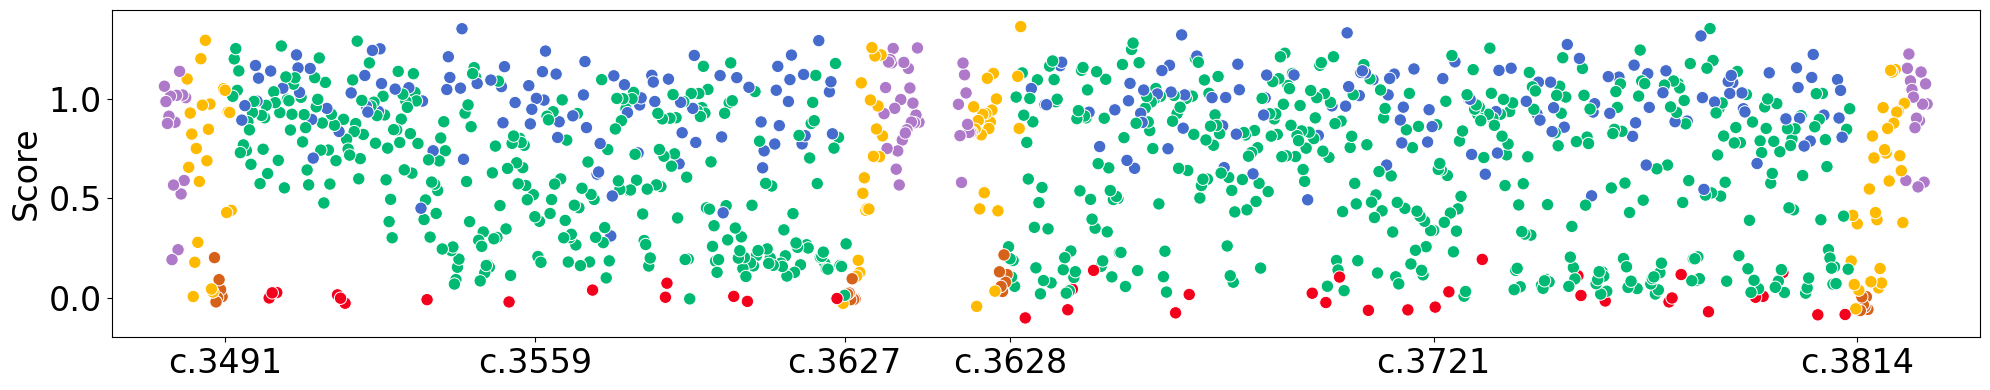

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def parse_c_variant(c_variant):
    """Parse c.variant notation to extract position and type"""
    variant = c_variant.replace('c.', '')
    
    if '+' in variant:
        match = re.match(r'(\d+)\+(\d+)', variant)
        if match:
            exon_pos = int(match.group(1))
            intronic_offset = int(match.group(2))
            return exon_pos, intronic_offset, 'intronic_plus'
    elif '-' in variant:
        match = re.match(r'(\d+)-(\d+)', variant)
        if match:
            exon_pos = int(match.group(1))
            intronic_offset = int(match.group(2))
            return exon_pos, intronic_offset, 'intronic_minus'
    else:
        match = re.match(r'(\d+)', variant)
        if match:
            exon_pos = int(match.group(1))
            return exon_pos, 0, 'exonic'
    
    return None, None, None

def identify_exon_boundaries(df):
    """Identify exon boundaries by finding intronic transitions"""
    # Look for intronic plus followed by intronic minus patterns
    # This indicates an exon boundary: c.X+Y followed by c.Z-W means exon ends at X, next starts at Z
    
    all_positions = sorted(df['base_pos'].dropna().unique())
    exons = []
    
    # Find positions where we have both plus and minus variants
    plus_positions = set(df[df['variant_type'] == 'intronic_plus']['base_pos'])
    minus_positions = set(df[df['variant_type'] == 'intronic_minus']['base_pos'])
    
    if not plus_positions and not minus_positions:
        # No intronic variants, treat all exonic as one exon
        exonic_positions = df[df['variant_type'] == 'exonic']['base_pos']
        if len(exonic_positions) > 0:
            return [(min(exonic_positions), max(exonic_positions))]
        else:
            return [(min(all_positions), max(all_positions))]
    
    # Sort all positions and identify exon boundaries
    current_exon_start = None
    current_exon_end = None
    
    for pos in all_positions:
        has_minus = pos in minus_positions
        has_plus = pos in plus_positions
        has_exonic = len(df[(df['base_pos'] == pos) & (df['variant_type'] == 'exonic')]) > 0
        
        if has_minus and current_exon_start is None:
            # This is the start of a new exon (intronic minus means before this exon)
            current_exon_start = pos
        
        if has_exonic:
            if current_exon_start is None:
                current_exon_start = pos
            current_exon_end = pos
        
        if has_plus and current_exon_start is not None:
            # This position has intronic plus (after exon), so exon ends here
            if current_exon_end is None:
                current_exon_end = pos
            exons.append((current_exon_start, current_exon_end))
            current_exon_start = None
            current_exon_end = None
    
    # Handle case where last exon doesn't have intronic plus
    if current_exon_start is not None:
        if current_exon_end is None:
            current_exon_end = current_exon_start
        exons.append((current_exon_start, current_exon_end))
    
    # If no exons found, create one big exon
    if not exons:
        return [(min(all_positions), max(all_positions))]
    
    return exons

def assign_plot_positions(df, exon_gap=50):
    """Assign x-axis positions based on c.variant logic"""
    
    # Parse variants
    df = df.copy()
    df[['base_pos', 'intronic_offset', 'variant_type']] = df['c_variant'].apply(
        lambda x: pd.Series(parse_c_variant(x))
    )
    
    # Identify exons
    exons = identify_exon_boundaries(df)
    
    # Assign each variant to its exon
    def assign_to_exon(base_pos):
        for i, (start, end) in enumerate(exons):
            if start <= base_pos <= end:
                return i
        return 0  # Default to first exon if not found
    
    df['exon'] = df['base_pos'].apply(assign_to_exon)
    
    # Now assign plot positions
    current_x = 0
    df['plot_x'] = 0
    
    for exon_idx, (exon_start, exon_end) in enumerate(exons):
        exon_data = df[df['exon'] == exon_idx].copy()
        
        if len(exon_data) == 0:
            continue
        
        # Sort variants within this exon by position and type
        # Order: minus variants (by decreasing offset), exonic variants, plus variants (by increasing offset)
        
        for _, variant in exon_data.iterrows():
            pos = variant['base_pos']
            v_type = variant['variant_type']
            offset = variant['intronic_offset']
            
            if v_type == 'intronic_minus':
                # Position based on: exon_position - intronic_offset
                # Larger offsets (further from exon) come first
                sort_key = (pos, -offset, 0)  # 0 for minus
            elif v_type == 'exonic':
                sort_key = (pos, 0, 1)  # 1 for exonic
            elif v_type == 'intronic_plus':
                # Position based on: exon_position + intronic_offset
                sort_key = (pos, offset, 2)  # 2 for plus
            else:
                sort_key = (pos, 0, 1)
            
            df.loc[variant.name, 'sort_key'] = str(sort_key)
        
        # Sort this exon's variants
        exon_data_sorted = exon_data.sort_values(['base_pos', 'variant_type', 'intronic_offset'])
        
        # For each position, sort: minus (desc offset), exonic, plus (asc offset)
        sorted_variants = []
        for pos in sorted(exon_data['base_pos'].unique()):
            pos_variants = exon_data[exon_data['base_pos'] == pos]
            
            # Minus variants (furthest from exon first)
            minus_vars = pos_variants[pos_variants['variant_type'] == 'intronic_minus'].sort_values('intronic_offset', ascending=False)
            sorted_variants.extend(minus_vars.index.tolist())
            
            # Exonic variants
            exonic_vars = pos_variants[pos_variants['variant_type'] == 'exonic']
            sorted_variants.extend(exonic_vars.index.tolist())
            
            # Plus variants (closest to exon first)
            plus_vars = pos_variants[pos_variants['variant_type'] == 'intronic_plus'].sort_values('intronic_offset', ascending=True)
            sorted_variants.extend(plus_vars.index.tolist())
        
        # Assign x positions
        for variant_idx in sorted_variants:
            df.loc[variant_idx, 'plot_x'] = current_x
            current_x += 2
        
        # Add gap between exons (except after last exon)
        if exon_idx < len(exons) - 1:
            current_x += exon_gap
    
    return df, exons

def create_variant_plot(df, colors, figsize=(20, 4)):
    """Create the variant plot with proper c.variant positioning"""
    
    # Assign plot positions
    df_positioned, exons = assign_plot_positions(df)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    sns.scatterplot(data=df_positioned, 
                    x='plot_x', 
                    y='average_score_norm', 
                    hue='consequence', 
                    palette=colors, 
                    legend=False,
                    s=80)
    
    # Customize plot
    plt.xlabel("", fontsize=0)
    plt.ylabel("Score", fontsize=24)
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24)
    plt.ylim(-0.2, 1.45)
    
    # Create x-axis labels using only EXONIC positions (no intronic +/-)
    x_ticks = []
    x_labels = []
    
    for exon_idx, (exon_start, exon_end) in enumerate(exons):
        exon_data = df_positioned[df_positioned['exon'] == exon_idx]
        if len(exon_data) == 0:
            continue
        
        # Get only EXONIC variants for this exon
        exonic_data = exon_data[exon_data['variant_type'] == 'exonic']
        
        if len(exonic_data) == 0:
            continue
            
        # Get unique exonic c.positions and their corresponding plot_x values
        position_mapping = {}
        for _, row in exonic_data.iterrows():
            pos = int(row['base_pos'])
            plot_x = row['plot_x']
            if pos not in position_mapping:
                position_mapping[pos] = []
            position_mapping[pos].append(plot_x)
        
        # Average plot_x for each position (in case multiple exonic variants at same position)
        position_plot_x = {}
        for pos, x_values in position_mapping.items():
            position_plot_x[pos] = sum(x_values) / len(x_values)
        
        # Sort positions by their actual plot_x values
        sorted_positions = sorted(position_plot_x.keys(), key=lambda p: position_plot_x[p])
        
        if len(sorted_positions) >= 3:
            # First exonic, middle exonic, last exonic
            first_pos = sorted_positions[0]
            mid_pos = sorted_positions[len(sorted_positions) // 2]
            last_pos = sorted_positions[-1]
            
            x_ticks.extend([position_plot_x[first_pos], position_plot_x[mid_pos], position_plot_x[last_pos]])
            x_labels.extend([f'c.{first_pos}', f'c.{mid_pos}', f'c.{last_pos}'])
        elif len(sorted_positions) == 2:
            # First and last exonic
            first_pos = sorted_positions[0]
            last_pos = sorted_positions[-1]
            
            x_ticks.extend([position_plot_x[first_pos], position_plot_x[last_pos]])
            x_labels.extend([f'c.{first_pos}', f'c.{last_pos}'])
        elif len(sorted_positions) == 1:
            # Just one exonic position
            pos = sorted_positions[0]
            x_ticks.append(position_plot_x[pos])
            x_labels.append(f'c.{pos}')
    
    if x_ticks:
        plt.xticks(x_ticks, x_labels)
    
    # Crop white space by setting x-limits closer to actual data range
    if len(df_positioned) > 0:
        x_min = df_positioned['plot_x'].min()
        x_max = df_positioned['plot_x'].max() 
        x_range = x_max - x_min
        # Add small buffer (3% of data range on each side)
        buffer = x_range * 0.03
        plt.xlim(x_min - buffer, x_max + buffer)
    
    plt.tight_layout()
    
    return df_positioned

df_positioned = create_variant_plot(C10_data_mapped, colors)
plt.savefig("MYBPC3_exon_dots.png", dpi=300, bbox_inches='tight')

In [13]:
"""
PyMOL script to identify inward-facing (buried) vs outward-facing (exposed) sidechains
in the C10 Ig-like domain based on geometric orientation relative to domain center
Additionally identifies outward residues within 10Å of MYH7 chains
Outputs classification to DataFrame
Updated: Added glycines as neon spheres at CA, more transparent MYH7 surface, swapped colors
"""

from pymol import cmd, stored
import numpy as np
import pandas as pd

# === Parameters ===
pdb_file = "8G4L_subset.cif"
mybpc3_chain = "ao"
c10_start = 1164
c10_end = 9999  # Go to end of protein
output_pml = "c10_inward_outward_scores.pml"
output_pse = "c10_inward_outward_scores.pse"
output_csv = "c10_classification.csv"
myh7_distance_cutoff = 10.0  # Angstroms
score_threshold = 0.4259  # Threshold for showing spheres
base_sphere_size = 0.5  # Starting size for sphere
size_increment = 0.1  # Size increase per variant below threshold

# Load score data - UPDATE THIS PATH TO YOUR ACTUAL FILE
score_file =   "Supplementary_table_1_MYBPC3_C10_scores_VEP_CV.csv"

def get_coordinates(selection):
    """Get xyz coordinates for a selection"""
    coords = []
    cmd.iterate_state(1, selection, "coords.append((x, y, z))", space={'coords': coords})
    return np.array(coords) if coords else None

def analyze_sidechain_orientation(score_df=None):
    """Determine if sidechains point inward or outward from fold center"""
    
    # AGGRESSIVE CLEANUP - DELETE ALL POSSIBLE GRAY SPHERE SOURCES
    cmd.delete("all")
    cmd.hide("everything")
    cmd.remove("all")  # Remove atoms if delete doesn't work
    
    # Load structure fresh
    cmd.load(pdb_file, "structure")
    
    # IMMEDIATELY hide all spheres to prevent any default sphere visualization
    cmd.hide("spheres", "all")
    cmd.hide("spheres", "structure")
    cmd.set("sphere_scale", 0.0, "all")  # Set all sphere scales to zero initially
    
    # Load and process score data
    variants_below_threshold = {}
    glycine_positions = []  # Track glycine positions
    
    if score_df is not None:
        print(f"\n{'='*80}")
        print(f"PROCESSING SCORE DATA")
        print(f"{'='*80}")
        print(f"Dataframe shape: {score_df.shape}")
        print(f"Columns found: {score_df.columns.tolist()}")
        
        if 'average_score_norm' in score_df.columns and 'p_variant' in score_df.columns:
            # Filter out rows where p_variant is NaN (intronic variants)
            score_df_clean = score_df.dropna(subset=['p_variant']).copy()
            print(f"\nAfter removing NaN p_variants: {len(score_df_clean)} rows")
            
            print(f"\nFirst few rows:")
            print(score_df_clean[['p_variant', 'average_score_norm']].head(10))
            
            # Extract numeric position from p_variant (e.g., R866Q -> 866)
            score_df_clean['aa_pos'] = score_df_clean['p_variant'].str.extract(r'(\d+)').astype(int)
            
            print(f"\nExtracted positions from p_variant:")
            print(score_df_clean[['p_variant', 'aa_pos']].head(10))
            
            # Show score distribution
            print(f"\nScore statistics:")
            print(score_df_clean['average_score_norm'].describe())
            print(f"Threshold: {score_threshold}")
            
            # Filter for scores below threshold
            below_threshold = score_df_clean[score_df_clean['average_score_norm'] < score_threshold].copy()
            print(f"\n*** Found {len(below_threshold)} variants with score < {score_threshold} ***")
            
            if len(below_threshold) > 0:
                print(f"\nFirst 10 variants below threshold:")
                print(below_threshold[['p_variant', 'aa_pos', 'average_score_norm']].head(10))
            
            # Use aa_pos column that we just created
            below_threshold['pos'] = below_threshold['aa_pos'].astype(str)
            
            # Count variants per position
            for pos, group in below_threshold.groupby('pos'):
                variants_below_threshold[str(int(float(pos)))] = len(group)
                    
            print(f"\n*** {len(variants_below_threshold)} POSITIONS with variants below threshold ***")
            # Show ALL positions as examples
            example_positions = sorted(list(variants_below_threshold.items()), key=lambda x: int(x[0]))
            for pos, count in example_positions:
                print(f"  Position {pos}: {count} variants below threshold")
        else:
            print(f"\n*** ERROR: Required columns not found! ***")
            print(f"Need 'average_score_norm' and 'p_variant'")
            print(f"Available columns: {score_df.columns.tolist()}")
    else:
        print("\n*** WARNING: No score data provided - no spheres will be shown ***")
    # Create object with ONLY chain ao
    cmd.create("chain_ao_only", f"structure and chain {mybpc3_chain}")
    
    # Create MYH7 surface object (all chains except MYBPC3 chain ao - INCLUDE chain af)
    cmd.create("myh7_surface", f"structure and not chain {mybpc3_chain}")
    
    # Define C10 domain selection - from 1164 to end of chain
    c10_sel = f"chain_ao_only and resi {c10_start}-"
    
    # Show cartoon for MYBPC3 C10 domain ONLY
    cmd.show("cartoon", c10_sel)
    cmd.set("cartoon_fancy_helices", 1)
    
    # EXPLICITLY prevent any sphere visualization except where we want it
    cmd.hide("spheres", "all")
    cmd.hide("spheres", "structure") 
    cmd.hide("spheres", c10_sel)
    
    # Show MYH7 as lighter gray surface (INCLUDING chain af)
    cmd.show("surface", "myh7_surface")
    cmd.color("gray90", "myh7_surface")  # Light gray surface
    cmd.set("transparency", 0.0, "myh7_surface")  # Slightly transparent
    
    # Use a fixed center point instead of calculating it
    domain_center = np.array([490.0, 483.0, 561.0])  # Approximate center from your data
    print(f"\nUsing fixed domain center: {domain_center}")
    
    # Get residue information
    stored.residues = []
    cmd.iterate(f"{c10_sel} and name CA", "stored.residues.append((resi, resn))")
    
    # Storage for classification
    inward_residues = []
    outward_residues = []
    outward_myh7_residues = []
    
    # DataFrame to store results
    results = []
    
    print(f"\nAnalyzing sidechain orientations in C10 domain")
    print(f"Chain {mybpc3_chain}, residues {c10_start} to end of protein")
    print("-" * 85)
    print("Residue    CA->SC   Orient     Dist    MYH7    Classification")
    print("-" * 85)
    
    for resi, resn in stored.residues:
        # Handle glycine specially - show as neon sphere at CA
        if resn == "GLY":
            glycine_positions.append(resi)
            
            # Show glycine as neon sphere at CA if it has variants below threshold
            if resi in variants_below_threshold:
                num_variants = variants_below_threshold[resi]
                sphere_size = base_sphere_size + (num_variants - 1) * size_increment
                
                ca_sel = f"chain_ao_only and resi {resi} and name CA"
                cmd.color("neon", ca_sel)
                cmd.show("spheres", ca_sel)
                cmd.set("sphere_scale", sphere_size, ca_sel)
                print(f"    {resn}{resi:4}: GLY with {num_variants} variants, neon sphere at CA (size={sphere_size:.1f})")
            else:
                print(f"    {resn}{resi:4}: No sidechain (GLY)")
            
            results.append({
                'residue': f"{resn}{resi}",
                'resn': resn,
                'resi': int(resi),
                'dot_product': np.nan,
                'distance_to_center': np.nan,
                'class': 'GLY'
            })
            continue
            
        # Get CA position - using iterate instead of get_coordinates to avoid markers
        ca_pos = None
        coords = []
        cmd.iterate_state(1, f"chain_ao_only and resi {resi} and name CA", "coords.append((x, y, z))", space={'coords': coords})
        if coords:
            ca_pos = np.array(coords[0])
        else:
            continue
        
        # Get CB position - using iterate instead of get_coordinates  
        cb_pos = None
        coords = []
        cmd.iterate_state(1, f"chain_ao_only and resi {resi} and name CB", "coords.append((x, y, z))", space={'coords': coords})
        if coords:
            cb_pos = np.array(coords[0])
        else:
            continue
        
        # Get sidechain center - using iterate instead of get_coordinates
        # For different residues, use appropriate atoms
        if resn in ['VAL', 'ILE', 'LEU']:
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CG1+CG2+CD+CD1+CD2"
        elif resn == 'PHE':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD1+CD2+CE1+CE2+CZ"
        elif resn == 'TYR':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD1+CD2+CE1+CE2+CZ+OH"
        elif resn == 'TRP':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD1+CD2+NE1+CE2+CE3+CZ2+CZ3+CH2"
        elif resn == 'ARG':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD+NE+CZ+NH1+NH2"
        elif resn == 'LYS':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD+CE+NZ"
        elif resn == 'MET':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+SD+CE"
        elif resn == 'CYS':
            sc_sel = f"chain_ao_only and resi {resi} and name SG"
        elif resn == 'SER':
            sc_sel = f"chain_ao_only and resi {resi} and name OG"
        elif resn == 'THR':
            sc_sel = f"chain_ao_only and resi {resi} and name OG1+CG2"
        elif resn == 'ASN':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+OD1+ND2"
        elif resn == 'GLN':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD+OE1+NE2"
        elif resn == 'ASP':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+OD1+OD2"
        elif resn == 'GLU':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD+OE1+OE2"
        elif resn == 'HIS':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+ND1+CD2+CE1+NE2"
        elif resn == 'PRO':
            sc_sel = f"chain_ao_only and resi {resi} and name CG+CD"
        else:  # ALA or unknown
            sc_sel = f"chain_ao_only and resi {resi} and name CB"
            
        # Get sidechain coordinates using iterate
        coords = []
        cmd.iterate_state(1, sc_sel, "coords.append((x, y, z))", space={'coords': coords})
        if coords:
            sc_pos = np.mean(np.array(coords), axis=0)  # Center of mass of sidechain
        else:
            sc_pos = cb_pos  # Fall back to CB if no other atoms
        
        # Calculate vectors
        ca_to_center = domain_center - ca_pos
        ca_to_sc = sc_pos - ca_pos
        
        # Normalize vectors
        ca_to_center_norm = ca_to_center / np.linalg.norm(ca_to_center)
        ca_to_sc_norm = ca_to_sc / np.linalg.norm(ca_to_sc) if np.linalg.norm(ca_to_sc) > 0 else ca_to_sc
        
        # Calculate dot product to determine if pointing inward or outward
        dot_product = np.dot(ca_to_center_norm, ca_to_sc_norm)
        
        # Distance from CA to domain center
        distance_to_center = np.linalg.norm(ca_to_center)
        
        # Classification based on dot product AND distance
        charged_residues = ['LYS', 'ARG', 'ASP', 'GLU']
        is_charged = resn in charged_residues
        
        # N-terminal residues (up to 1179) are always outward
        if int(resi) <= 1179:
            orientation = "OUTWARD"
            marker = "   "
            is_inward = False
        else:
            # Normal classification for core region residues (1180+)
            if distance_to_center > 15:  # Far from center
                inward_threshold = 0.3 if not is_charged else 0.5
                outward_threshold = -0.1
            elif distance_to_center > 10:  # Medium distance
                inward_threshold = 0.15 if not is_charged else 0.35
                outward_threshold = -0.2
            else:  # Close to center (within 10Å)
                # Very lenient for close residues - even slightly inward counts
                inward_threshold = 0.0 if not is_charged else 0.2
                outward_threshold = -0.3
            
            # Special override for specific residues
            force_exposed = ['1261', '1265']  # GLU1261, GLU1265 are surface residues
            force_inward = ['1200', '1251', '1255', '1210', '1181', '1247', '1257']  # Including 1247 and 1257
            
            # Determine orientation
            if resi in force_inward:  # ALWAYS force these as inward, no conditions
                orientation = "INWARD"
                marker = ">>>"
                is_inward = True
            elif resi in force_exposed:
                orientation = "OUTWARD"
                marker = " ! "
                is_inward = False
            elif dot_product > inward_threshold:
                # Additional check for charged residues far from center
                if is_charged and distance_to_center > 12:
                    orientation = "OUTWARD"
                    marker = " * "
                    is_inward = False
                else:
                    orientation = "INWARD"
                    marker = ">>>"
                    is_inward = True
            elif dot_product < outward_threshold:
                orientation = "OUTWARD"
                marker = "   "
                is_inward = False
            else:
                orientation = "LATERAL"
                marker = " | "
                is_inward = False
        
        # Check proximity to MYH7 chains (if residue is outward-facing)
        # EXCLUDING chain af which is also MYBPC3, not MYH7
        near_myh7 = False
        myh7_marker = ""
        if not is_inward:
            # Check distance to any MYH7 chain (excluding both ao and af)
            cb_sel = f"chain_ao_only and resi {resi} and name CB"
            myh7_selection = f"structure and not (chain {mybpc3_chain} or chain af) and name CA"
            
            # Use cmd.select to find atoms within distance - NO VISUALIZATION
            nearby_sel = f"nearby_myh7_{resi}"
            cmd.select(nearby_sel, f"{myh7_selection} within {myh7_distance_cutoff} of ({cb_sel})")
            
            # Count atoms in selection
            count = cmd.count_atoms(nearby_sel)
            if count > 0:
                near_myh7 = True
                myh7_marker = "MYH7"
            
            # Clean up temporary selection immediately
            cmd.delete(nearby_sel)
        
        # Determine final classification and color (SWAPPED GOLD/IRON)
        if is_inward:
            classification = "inward"
            color = "slate"  # Slate for inward
            inward_residues.append(f"{resn}{resi}")
        elif near_myh7:
            classification = "outward_MYH7"
            color = "gold"  # SWAPPED: gold for outward MYH7
            outward_myh7_residues.append(f"{resn}{resi}")
        else:
            classification = "outward"
            color = "iron"  # SWAPPED: iron for regular outward
            outward_residues.append(f"{resn}{resi}")
        
        # Only show sphere if position has variants below threshold
        if resi in variants_below_threshold:
            num_variants = variants_below_threshold[resi]
            sphere_size = base_sphere_size + (num_variants - 1) * size_increment
            
            cb_sel = f"chain_ao_only and resi {resi} and name CB"
            cmd.color(color, cb_sel)
            cmd.show("spheres", cb_sel)  # ONLY show spheres for CB atoms with scores
            cmd.set("sphere_scale", sphere_size, cb_sel)
            
            # Set transparency for inward (slate) spheres only
            if is_inward:
                cmd.set("sphere_transparency", 0, cb_sel)  # 30% transparent for buried residues
            else:
                cmd.set("sphere_transparency", 0.0, cb_sel)  # Fully opaque for exposed residues
            
            # Debug output for first few spheres
            if len(variants_below_threshold) < 10 or resi in ['1200', '1253', '1255']:
                print(f"  Setting sphere for {resn}{resi}: {num_variants} variants, size={sphere_size:.1f}")
        else:
            # EXPLICITLY HIDE any spheres for positions without variants
            cb_sel = f"chain_ao_only and resi {resi} and name CB"
            cmd.hide("spheres", cb_sel)
        
        # Special marking for key residues
        special = ""
        if resi in ['1202', '1253', '1255']:
            special = " <- key"
        elif resi in ['1261', '1265']:
            special = " <- surface"
            
        print(f"{marker} {resn}{resi:4}: {dot_product:5.2f}  {orientation:8}  {distance_to_center:5.1f}  {myh7_marker:4}  {classification:15} {special}")
        
        # Store results
        results.append({
            'residue': f"{resn}{resi}",
            'resn': resn,
            'resi': int(resi),
            'dot_product': dot_product,
            'distance_to_center': distance_to_center,
            'class': classification
        })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\nClassification saved to: {output_csv}")
    
    # Check specific residues
    print("\n=== VALIDATION OF KEY RESIDUES ===")
    print("Expected inward-facing (buried in core):")
    for resi in ['1202', '1253', '1255']:
        res_match = next((r for r in stored.residues if r[0] == resi), None)
        if res_match:
            resn = res_match[1]
            res_str = f"{resn}{resi}"
            if res_str in inward_residues:
                print(f"  {res_str}: ✓ INWARD")
            else:
                print(f"  {res_str}: ✗ NOT INWARD")
    
    print("\nExpected outward-facing (surface):")
    for resi in ['1261', '1265']:
        res_match = next((r for r in stored.residues if r[0] == resi), None)
        if res_match:
            resn = res_match[1]
            res_str = f"{resn}{resi}"
            if res_str in (outward_residues + outward_myh7_residues):
                print(f"  {res_str}: ✓ OUTWARD")
            else:
                print(f"  {res_str}: ✗ NOT OUTWARD")
    
    # Report hydrophobic core
    core_hydrophobic = [r for r in inward_residues if any(r.startswith(aa) for aa in 
                       ['VAL', 'LEU', 'ILE', 'MET', 'PHE', 'TRP', 'ALA', 'TYR'])]
    if core_hydrophobic:
        print(f"\n=== HYDROPHOBIC CORE (INWARD-FACING) ===")
        for i in range(0, len(core_hydrophobic), 8):
            print(f"  {', '.join(core_hydrophobic[i:i+8])}")
    
    # Report MYH7-proximal residues (UPDATED COLOR NAME)
    if outward_myh7_residues:
        print(f"\n=== MYH7-PROXIMAL RESIDUES (GOLD) ===")  # Updated from IRON to GOLD
        for i in range(0, len(outward_myh7_residues), 8):
            print(f"  {', '.join(outward_myh7_residues[i:i+8])}")
    
    # Report glycines if any have spheres
    glycines_with_spheres = [f"GLY{g}" for g in glycine_positions if g in variants_below_threshold]
    if glycines_with_spheres:
        print(f"\n=== GLYCINES WITH VARIANTS (NEON) ===")
        print(f"  {', '.join(glycines_with_spheres)}")
    
    # Color backbone in neon
    cmd.color("neon", f"{c10_sel} and name N+C+O+CA")
    
    # Create selections for CB atoms only (and CA for glycines)
    if inward_residues:
        cmd.select("buried_sidechains", f"{c10_sel} and resi {'+'.join([r[3:] for r in inward_residues])} and name CB")
    if outward_residues:
        cmd.select("exposed_sidechains", f"{c10_sel} and resi {'+'.join([r[3:] for r in outward_residues])} and name CB")
    if outward_myh7_residues:
        cmd.select("exposed_myh7_sidechains", f"{c10_sel} and resi {'+'.join([r[3:] for r in outward_myh7_residues])} and name CB")
    if glycines_with_spheres:
        cmd.select("glycine_cas", f"{c10_sel} and resi {'+'.join([g[3:] for g in glycines_with_spheres])} and name CA")
    
    # Statistics
    total = len([r for r in results if r['class'] != 'GLY'])
    n_inward = len(inward_residues)
    n_outward = len(outward_residues)
    n_outward_myh7 = len(outward_myh7_residues)
    n_lateral = total - n_inward - n_outward - n_outward_myh7
    n_glycine = len(glycine_positions)
    n_glycine_spheres = len(glycines_with_spheres)
    n_with_spheres = len(variants_below_threshold)
    
    print("\n" + "=" * 85)
    print(f"C10 DOMAIN SIDECHAIN ORIENTATION STATISTICS:")
    print(f"  Total residues (excluding GLY): {total}")
    print(f"  Inward-facing (slate): {n_inward} ({100*n_inward/total:.1f}%)")
    print(f"  Outward-facing (iron): {n_outward} ({100*n_outward/total:.1f}%)")  # Updated color
    print(f"  Outward MYH7-proximal (gold): {n_outward_myh7} ({100*n_outward_myh7/total:.1f}%)")  # Updated color
    print(f"  Lateral (cyan): {n_lateral} ({100*n_lateral/total:.1f}%)")
    print(f"  Glycines total: {n_glycine}")
    print(f"  Glycines with spheres (neon at CA): {n_glycine_spheres}")
    print(f"  Total positions with spheres (score < {score_threshold}): {n_with_spheres}")
    print("=" * 85)
    
    # Save outputs
    cmd.zoom(c10_sel)
    cmd.select("c10_domain", c10_sel)
    
    # Generate PML script with updated colors and surface (SWAPPED COLORS)
    pml_commands = f"""# PyMOL script for C10 inward/outward beta carbon analysis with scores
# Beta carbons colored by sidechain orientation and sized by score
# Glycines shown as neon spheres at CA position
# Only positions with variants scoring < {score_threshold} are shown
# Updated: MYH7 as light gray surface (including chain af for visualization), swapped iron/gold colors
load {pdb_file}
create chain_ao_only, chain {mybpc3_chain}
create myh7_surface, not chain {mybpc3_chain}
hide everything

# Show MYBPC3 C10 domain cartoon
show cartoon, chain_ao_only and resi {c10_start}-
color neon, chain_ao_only and name N+C+O+CA
set cartoon_fancy_helices, 1

# Show MYH7 as lighter gray surface (INCLUDING chain af) - MUST BE AFTER hide everything
show surface, myh7_surface
color gray90, myh7_surface
set transparency, 0.0, myh7_surface

"""
    
    # Add commands for glycines with scores
    for g_pos in glycine_positions:
        if g_pos in variants_below_threshold:
            num_variants = variants_below_threshold[g_pos]
            sphere_size = base_sphere_size + (num_variants - 1) * size_increment
            pml_commands += f"# Glycine at position {g_pos}\n"
            pml_commands += f"show spheres, chain_ao_only and resi {g_pos} and name CA\n"
            pml_commands += f"color neon, chain_ao_only and resi {g_pos} and name CA\n"
            pml_commands += f"set sphere_scale, {sphere_size}, chain_ao_only and resi {g_pos} and name CA\n"
    
    # Add commands for each residue with scores (UPDATED COLORS - SWAPPED)
    for res_str in inward_residues:
        resi = res_str[3:]  # Extract position
        if resi in variants_below_threshold:
            num_variants = variants_below_threshold[resi]
            sphere_size = base_sphere_size + (num_variants - 1) * size_increment
            pml_commands += f"show spheres, chain_ao_only and resi {resi} and name CB\n"
            pml_commands += f"color slate, chain_ao_only and resi {resi} and name CB\n"
            pml_commands += f"set sphere_scale, {sphere_size}, chain_ao_only and resi {resi} and name CB\n"
            pml_commands += f"set sphere_transparency, 0, chain_ao_only and resi {resi} and name CB\n"  # Add transparency
    
    for res_str in outward_residues:
        resi = res_str[3:]
        if resi in variants_below_threshold:
            num_variants = variants_below_threshold[resi]
            sphere_size = base_sphere_size + (num_variants - 1) * size_increment
            pml_commands += f"show spheres, chain_ao_only and resi {resi} and name CB\n"
            pml_commands += f"color iron, chain_ao_only and resi {resi} and name CB\n"  # SWAPPED to iron
            pml_commands += f"set sphere_scale, {sphere_size}, chain_ao_only and resi {resi} and name CB\n"
    
    for res_str in outward_myh7_residues:
        resi = res_str[3:]
        if resi in variants_below_threshold:
            num_variants = variants_below_threshold[resi]
            sphere_size = base_sphere_size + (num_variants - 1) * size_increment
            pml_commands += f"show spheres, chain_ao_only and resi {resi} and name CB\n"
            pml_commands += f"color gold, chain_ao_only and resi {resi} and name CB\n"  # SWAPPED to gold
            pml_commands += f"set sphere_scale, {sphere_size}, chain_ao_only and resi {resi} and name CB\n"
    
    pml_commands += f"""
# Selections
select c10_domain, chain_ao_only and resi {c10_start}-

zoom chain_ao_only and resi {c10_start}-
bg_color white
set ray_shadows, 0
set ambient, 0.3
"""
    
    with open(output_pml, 'w') as f:
        f.write(pml_commands)
    print(f"\nSaved: {output_pml} (PML script)")
    
    cmd.save(output_pse)
    print(f"Saved: {output_pse} (PSE session)")

# Run analysis with score data if available
try:
    # Try to load the score file
    score_df = pd.read_csv(score_file)
    print(f"Successfully loaded {score_file}")
    analyze_sidechain_orientation(score_df)
except FileNotFoundError:
    print(f"Score file '{score_file}' not found - running without scores")
    analyze_sidechain_orientation(None)
except Exception as e:
    print(f"Error loading score file: {e}")
    analyze_sidechain_orientation(None)

# Visualization settings
cmd.set("ray_shadows", 0)
cmd.set("ambient", 0.3)
cmd.bg_color("white")

print("\nVisualization:")
print("  Sphere size based on variants below threshold:")
print(f"    Base size: {base_sphere_size} for 1 variant < {score_threshold}")
print(f"    +{size_increment} for each additional variant below threshold")
print("  SLATE spheres = Beta carbons of inward-facing sidechains (buried, 30% transparent)")
print("  IRON spheres = Beta carbons of outward-facing sidechains (surface exposed, opaque)")  # SWAPPED
print("  GOLD spheres = Beta carbons of outward residues within 10Å of MYH7 (opaque)")  # SWAPPED
print("  NEON spheres = Alpha carbons of glycines with variants below threshold (opaque)")
print("  LIGHT GRAY surface = MYH7 chains (including chain AF, slightly transparent)")
print(f"\nNote: Only positions with score < {score_threshold} are shown as spheres")
print("Note: Chain AF is part of MYH7 surface but excluded from distance calculations")

Successfully loaded Supplementary_table_1_MYBPC3_C10_scores_VEP_CV.csv

PROCESSING SCORE DATA
Dataframe shape: (1137, 20)
Columns found: ['seq', 'consequence', 'average_score_norm', 'c_variant', 'p_variant', 'Pos', 'hg38_coord', 'Ref', 'Alt', 'Chrom', 'CADD_RawScore', 'PHRED', 'protein_variant', 'am_pathogenicity', 'REVEL', 'Ensembl_transcriptid', 'EVE_scores_ASM', 'MutPred2 score', 'Name', 'ClinVar']

After removing NaN p_variants: 707 rows

First few rows:
   p_variant  average_score_norm
51    R1271Q             0.84829
52    R1271P             0.14317
53    R1271L             0.95223
55    R1271G             0.41072
56    R1271X            -0.08515
60    V1270E             0.06801
61    V1270A             0.15532
62    V1270G             0.07062
63    V1270M             0.24185
64    V1270L             0.19925

Extracted positions from p_variant:
   p_variant  aa_pos
51    R1271Q    1271
52    R1271P    1271
53    R1271L    1271
55    R1271G    1271
56    R1271X    1271
60    V1270

Loaded 1137 rows from Supplementary_table_1_MYBPC3_C10_scores_VEP_CV.csv
Columns found: ['seq', 'consequence', 'average_score_norm', 'c_variant', 'p_variant', 'Pos', 'hg38_coord', 'Ref', 'Alt', 'Chrom', 'CADD_RawScore', 'PHRED', 'protein_variant', 'am_pathogenicity', 'REVEL', 'Ensembl_transcriptid', 'EVE_scores_ASM', 'MutPred2 score', 'Name', 'ClinVar']
Extracting aa_pos from p_variant column...
Extracted positions from 707 variants
Extracting variant amino acid from p_variant...
Using 'var_aa' as variant amino acid column
Extracting reference amino acid from p_variant...


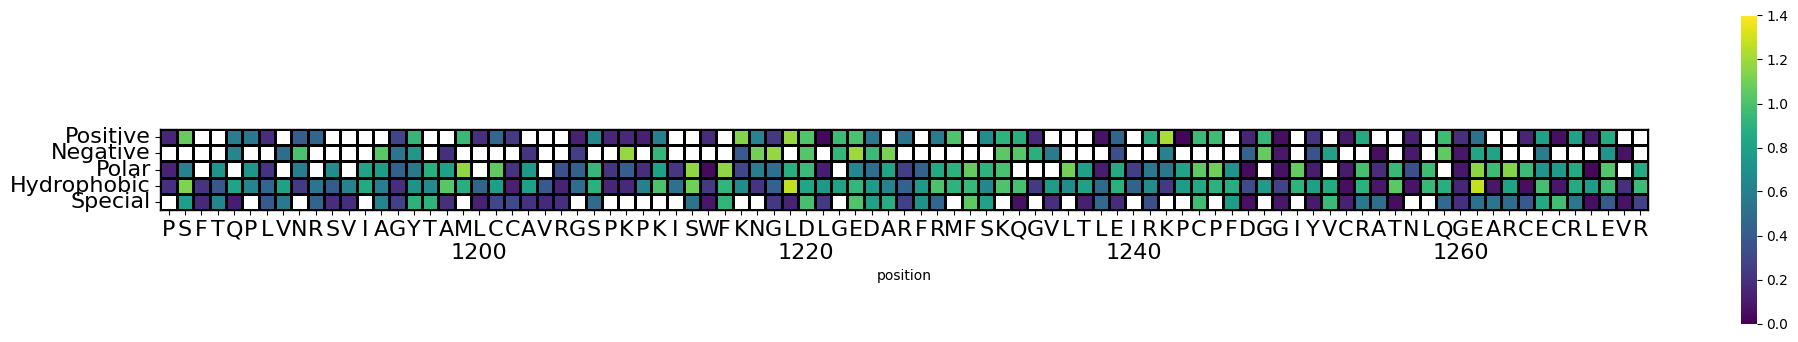


Heatmap created for 91 positions
Position range: 1181 to 1271

Color scheme:
  Heatmap: Viridis colormap (Dark purple = Low score (tolerant), Yellow = High score (pathogenic))
  Normalization: vmin=0.0, vmax=1.4


In [14]:
# Load the score file
score_df = C10_data_mapped

print(f"Loaded {len(score_df)} rows from {score_file}")
print(f"Columns found: {score_df.columns.tolist()}")

# Use the data as-is
missense_data = score_df.copy()

# Extract position from p_variant if aa_pos doesn't exist
if 'aa_pos' not in missense_data.columns:
    if 'p_variant' in missense_data.columns:
        print("Extracting aa_pos from p_variant column...")
        # Filter out NaN p_variants first
        missense_data = missense_data.dropna(subset=['p_variant']).copy()
        # Extract numeric position from p_variant (e.g., R866Q -> 866)
        missense_data['aa_pos'] = missense_data['p_variant'].str.extract(r'(\d+)').astype(int)
        print(f"Extracted positions from {len(missense_data)} variants")
    else:
        print("ERROR: Neither 'aa_pos' nor 'p_variant' column found!")
        raise ValueError("Required column 'aa_pos' or 'p_variant' not found in data")

if 'average_score_norm' not in missense_data.columns:
    print("ERROR: 'average_score_norm' column not found!")
    raise ValueError("Required column 'average_score_norm' not found in data")

# Determine variant amino acid column name
var_aa_col = None
if 'var_aa' in missense_data.columns:
    var_aa_col = 'var_aa'
elif 'alt_aa' in missense_data.columns:
    var_aa_col = 'alt_aa'
elif 'new_aa' in missense_data.columns:
    var_aa_col = 'new_aa'
else:
    # Try to extract from p_variant (e.g., R866Q -> Q is the variant)
    if 'p_variant' in missense_data.columns:
        print("Extracting variant amino acid from p_variant...")
        missense_data['var_aa'] = missense_data['p_variant'].str.extract(r'[A-Z]\d+([A-Z])')
        var_aa_col = 'var_aa'
    else:
        print(f"Available columns: {missense_data.columns.tolist()}")
        print("ERROR: Cannot find variant amino acid column (var_aa, alt_aa, or new_aa)")
        raise ValueError("Cannot find variant amino acid column")

print(f"Using '{var_aa_col}' as variant amino acid column")

# Determine reference amino acid column name
ref_aa_col = None
if 'ref_aa' in missense_data.columns:
    ref_aa_col = 'ref_aa'
elif 'wt_aa' in missense_data.columns:
    ref_aa_col = 'wt_aa'
else:
    # Try to extract from p_variant (e.g., R866Q -> R is the reference)
    if 'p_variant' in missense_data.columns:
        print("Extracting reference amino acid from p_variant...")
        missense_data['ref_aa'] = missense_data['p_variant'].str.extract(r'^([A-Z])\d+')
        ref_aa_col = 'ref_aa'
    else:
        print("Warning: No reference amino acid column found")
        ref_aa_col = None

# Clean the data
missense_data = missense_data.dropna(subset=['aa_pos', 'average_score_norm', var_aa_col])
missense_data['position'] = missense_data['aa_pos'].astype(int)

# Define amino acid groups based on biochemical properties
amino_acid_groups = {
    'Positive': ['R', 'H', 'K'],
    'Negative': ['D', 'E'],
    'Polar': ['S', 'T', 'N', 'Q'],
    'Hydrophobic': ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W'],
    'Special': ['C', 'G', 'P']
}

# Create reverse mapping from amino acid to group
aa_to_group = {}
for group_name, aas in amino_acid_groups.items():
    for aa in aas:
        aa_to_group[aa] = group_name

# Add amino acid group column based on variant amino acid
missense_data['aa_group'] = missense_data[var_aa_col].map(aa_to_group)
missense_data = missense_data.dropna(subset=['aa_group'])

# Get all unique positions starting at 1181
position_start = 1181
missense_data = missense_data[missense_data['position'] >= position_start]

# Get unique positions and reference amino acids
if ref_aa_col:
    position_data = missense_data.groupby('position').agg({
        ref_aa_col: 'first'
    }).sort_index()
    ref_aas_sorted = position_data[ref_aa_col].tolist()
else:
    # If no ref_aa column, just get positions
    position_data = missense_data.groupby('position').size().to_frame('count').sort_index()
    ref_aas_sorted = ['X'] * len(position_data)  # Use X as placeholder

positions_sorted = position_data.index.tolist()

# Calculate average scores for each amino acid group at each position
group_averages = missense_data.groupby(['aa_group', 'position'])['average_score_norm'].mean().reset_index()

# Create a pivot table for the heatmap
heatmap_data = group_averages.pivot_table(
    index='aa_group', 
    columns='position', 
    values='average_score_norm',
    aggfunc='mean'
)

# Define the order of amino acid groups
group_order = ['Positive', 'Negative', 'Polar', 'Hydrophobic', 'Special']
heatmap_data = heatmap_data.reindex(group_order)

# Create figure with just the scores heatmap
n_positions = len(positions_sorted)
square_size = 0.3
max_width = 24
max_height = 8
fig_width = min(max_width, max(16, n_positions * square_size + 4))
fig_height = min(max_height, max(4, len(group_order) * square_size + 2))

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# SCORES HEATMAP (amino acid groups) - using viridis colormap
sns.heatmap(heatmap_data, 
            cmap='viridis',
            cbar=True,
            linewidths=1,
            linecolor='black',
            square=True,
            annot=False,
            vmin=0.0,
            vmax=1.4,
            yticklabels=group_order,
            ax=ax)

# Add black border around heatmap
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
    spine.set_visible(True)

# Set labels
ax.set_ylabel('', fontsize=24)

# Create x-axis labels with reference amino acid
x_tick_positions = np.arange(len(positions_sorted)) + 0.5
ref_aa_labels = []
for i, (pos, ref_aa) in enumerate(zip(positions_sorted, ref_aas_sorted)):
    if pos % 20 == 0:  # Show position number every 20th position
        ref_aa_labels.append(f"{ref_aa}\n{pos}")
    else:
        ref_aa_labels.append(ref_aa)

# Set x-axis ticks and labels
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(ref_aa_labels, rotation=0, fontsize=16)
ax.set_yticklabels(group_order, fontsize=16)

# Ensure all borders are visible
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

# Save the plot
plt.savefig('MYBPC3_heatmap_scores_viridis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Print summary
print(f"\nHeatmap created for {n_positions} positions")
print(f"Position range: {min(positions_sorted)} to {max(positions_sorted)}")
print("\nColor scheme:")
print("  Heatmap: Viridis colormap (Dark purple = Low score (tolerant), Yellow = High score (pathogenic))")
print("  Normalization: vmin=0.0, vmax=1.4")


Total rows loaded: 707
Has aa_pos: 707 rows

Classification results:
class
outward         361
inward          173
outward_MYH7    173
Name: count, dtype: int64

Plotting 707 variants

Scatter plot saved as: figure_scatter_plot.png

CORRELATION STATISTICS

Overall correlation: r = -0.6107
Buried correlation: r = -0.6864 (n=173)
Exposed correlation: r = -0.5812 (n=361)
Exposed Lmm correlation: r = -0.2774 (n=173)

Group counts:
  Buried: 173
  Exposed: 361
  Exposed Lmm: 173

Classification agreement (using thresholds 0.426, 0.564):
  Both pathogenic: 110 (15.6%)
  Both benign: 41 (5.8%)
  Discordant: 556 (78.6%)


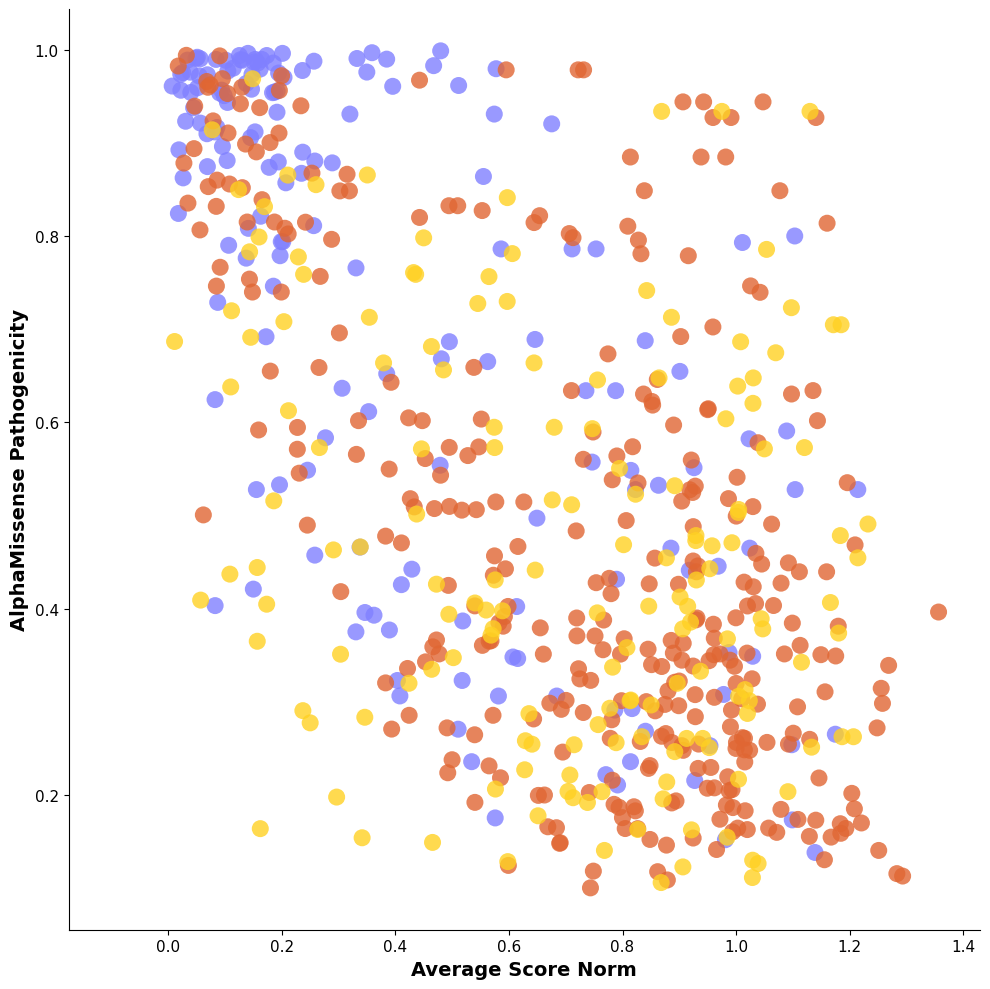

In [18]:
def create_publication_scatter_plot(merged_df_path='Supplementary_table_1_MYBPC3_C10_scores_VEP_CV.csv',
                                   output_file='publication_scatter_plot.png',
                                   score_threshold=0.4259,
                                   am_threshold=0.564,
                                   figure_size=(10, 10),
                                   dpi=300):
    """
    Create a publication-quality square scatter plot comparing two scoring methods
    """
    
    # Load data
    df = pd.read_csv(merged_df_path)
    
    # Extract aa_pos from p_variant if needed
    if 'aa_pos' not in df.columns and 'p_variant' in df.columns:
        df = df.dropna(subset=['p_variant']).copy()
        df['aa_pos'] = df['p_variant'].str.extract(r'(\d+)').astype(int)
    
    print(f"\nTotal rows loaded: {len(df)}")
    print(f"Has aa_pos: {df['aa_pos'].notna().sum()} rows")
    
    # === CLASSIFY RESIDUES AS INWARD/OUTWARD ===
    # Domain center for C10
    domain_center = np.array([490.0, 483.0, 561.0])
    
    # Define charged residues
    charged_residues = ['LYS', 'ARG', 'ASP', 'GLU', 'K', 'R', 'D', 'E']
    
    # Get residue name from p_variant (e.g., R866Q -> R is ref)
    if 'p_variant' in df.columns:
        df['ref_aa_3letter'] = df['p_variant'].str.extract(r'^([A-Z])\d+')[0]
        # Map to 3-letter code (simplified - add more if needed)
        aa_map = {'R': 'ARG', 'K': 'LYS', 'D': 'ASP', 'E': 'GLU', 
                  'H': 'HIS', 'S': 'SER', 'T': 'THR', 'N': 'ASN', 'Q': 'GLN',
                  'C': 'CYS', 'G': 'GLY', 'P': 'PRO', 'A': 'ALA', 'V': 'VAL',
                  'I': 'ILE', 'L': 'LEU', 'M': 'MET', 'F': 'PHE', 'Y': 'TYR', 'W': 'TRP'}
        df['resn'] = df['ref_aa_3letter'].map(aa_map)
    
    # For this simplified version, we'll use a rule-based approach without actual structure
    # You can load actual CA/CB coordinates if you have them
    
    def classify_residue(row):
        """Classify residue as inward/outward/outward_MYH7"""
        pos = row['aa_pos']
        resn = row.get('resn', 'UNK')
        
        # N-terminal residues (up to 1179) are always outward
        if pos <= 1179:
            return 'outward'
        
        # Force specific residues based on known structure
        force_inward = [1200, 1251, 1255, 1210, 1181, 1247, 1257, 
                       1183, 1187, 1192, 1198, 1202, 1204, 1212, 1214,
                       1216, 1229, 1231, 1236, 1238, 1240, 1243, 1262, 1264, 1266, 1268, 1273]
        force_exposed = [1261, 1265]
        
        if pos in force_inward:
            return 'inward'
        elif pos in force_exposed:
            return 'outward'
        
        # MYH7-proximal positions (within 10Å of MYH7)
        myh7_proximal = [1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
                        1173, 1174, 1175, 1176, 1177, 1179, 1184, 1185,
                        1188, 1193, 1196, 1199, 1201, 1203, 1205, 1207,
                        1208, 1209, 1211, 1223, 1224, 1225, 1226, 1228,
                        1230, 1232, 1233, 1235, 1237, 1239, 1241]
        
        if pos in myh7_proximal:
            return 'outward_MYH7'
        
        # Default classification for remaining positions
        # Positions > 1250 tend to be more surface exposed
        if pos >= 1250:
            return 'outward'
        else:
            # Could be either - default to outward for safety
            return 'outward'
    
    # Apply classification
    df['class'] = df.apply(classify_residue, axis=1)
    
    print(f"\nClassification results:")
    print(df['class'].value_counts())
    
    # Manual override for specific positions (as in original)
    df.loc[df['aa_pos'] == 1210, 'class'] = 'inward'
    df.loc[df['aa_pos'] == 1181, 'class'] = 'inward'
    
    # Rename classifications for publication
    df['class'] = df['class'].replace({
        'inward': 'buried',
        'outward': 'exposed',
        'outward_MYH7': 'exposed_LMM'
    })
    
    # HEATMAP COLOR PALETTE (matching PyMOL script)
    color_palette = {
        'buried': '#8080FF',        # Slate
        'exposed': '#E06633',       # Iron
        'exposed_LMM': '#FFD123',   # Gold
    }
    
    # Define order for categories
    category_order = ['buried', 'exposed', 'exposed_LMM']
    
    # Filter for categories that exist in data
    plot_df = df[df['class'].notna()].copy()
    category_order = [c for c in category_order if c in plot_df['class'].unique()]
    
    print(f"\nPlotting {len(plot_df)} variants")
    
    # Create figure with publication settings - SQUARE PLOT
    fig, ax = plt.subplots(figsize=figure_size)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Calculate overall correlation for statistics
    corr = plot_df[['average_score_norm', 'am_pathogenicity']].corr().iloc[0, 1]
    
    # Plot each category with circles only
    for category in category_order:
        subset = plot_df[plot_df['class'] == category]
        if len(subset) > 0:
            # Create readable labels
            if category == 'buried':
                label = 'Buried'
            elif category == 'exposed':
                label = 'Exposed'
            elif category == 'exposed_LMM':
                label = 'Exposed LMM'
            
            # Set alpha - consistent across all categories
            alpha = 0.8
            
            ax.scatter(subset['average_score_norm'],
                      subset['am_pathogenicity'],
                      color=color_palette[category],
                      marker='o',
                      s=150,
                      alpha=alpha,
                      edgecolors='none',
                      label=label,
                      zorder=3)
    
    # Set axis labels
    ax.set_xlabel('Average Score Norm', fontsize=14, fontweight='bold')
    ax.set_ylabel('AlphaMissense Pathogenicity', fontsize=14, fontweight='bold')
    
    # Normal axis limits with small padding
    x_min, x_max = plot_df['average_score_norm'].min(), plot_df['average_score_norm'].max()
    y_min, y_max = plot_df['am_pathogenicity'].min(), plot_df['am_pathogenicity'].max()
    
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_file, dpi=dpi, bbox_inches='tight')
    print(f"\nScatter plot saved as: {output_file}")
    
    # Display statistics
    print("\n" + "="*60)
    print("CORRELATION STATISTICS")
    print("="*60)
    print(f"\nOverall correlation: r = {corr:.4f}")
    
    # Correlation by group
    for group in category_order:
        group_data = plot_df[plot_df['class'] == group]
        if len(group_data) > 5:
            group_corr = group_data[['average_score_norm', 'am_pathogenicity']].corr().iloc[0, 1]
            print(f"{group.replace('_', ' ').title()} correlation: r = {group_corr:.4f} (n={len(group_data)})")
    
    # Count statistics by group
    print(f"\nGroup counts:")
    for group in category_order:
        count = len(plot_df[plot_df['class'] == group])
        print(f"  {group.replace('_', ' ').title()}: {count}")
    
    # Agreement statistics
    if score_threshold and am_threshold:
        both_path = len(plot_df[(plot_df['average_score_norm'] > score_threshold) & 
                                (plot_df['am_pathogenicity'] > am_threshold)])
        both_benign = len(plot_df[(plot_df['average_score_norm'] <= score_threshold) & 
                                  (plot_df['am_pathogenicity'] <= am_threshold)])
        discordant = len(plot_df) - both_path - both_benign
        
        print(f"\nClassification agreement (using thresholds {score_threshold:.3f}, {am_threshold:.3f}):")
        print(f"  Both pathogenic: {both_path} ({100*both_path/len(plot_df):.1f}%)")
        print(f"  Both benign: {both_benign} ({100*both_benign/len(plot_df):.1f}%)")
        print(f"  Discordant: {discordant} ({100*discordant/len(plot_df):.1f}%)")
    
    plt.show()
    return fig, ax

if __name__ == "__main__":
    fig, ax = create_publication_scatter_plot(
        merged_df_path='Supplementary_table_1_MYBPC3_C10_scores_VEP_CV.csv',
        output_file='figure_scatter_plot.png',
        score_threshold=0.4259,
        am_threshold=0.564,
        figure_size=(10, 10),
        dpi=300
    )